<a href="https://colab.research.google.com/github/vlordier/colabs/blob/main/Copy_of_NLP_ValueNet_Dataset1_8(Complete_Notebook_ValueNet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [ ]:
!pip install transformers
from transformers import BertTokenizer, TFBertForSequenceClassification,RobertaTokenizer
from transformers import InputExample, InputFeatures
from transformers import  TFRobertaForSequenceClassification,RobertaTokenizer
import numpy as np
from google.colab import drive
import torch
from sklearn.metrics import confusion_matrix
from fastai.text import *
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import torch.nn as nn
from transformers import BertModel
from fastai.metrics import *
from transformers import BertTokenizer
import pandas as pd
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from transformers import RobertaModel
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,cross_val_predict
import sys
sys.path.append('..')
import logging
logging.getLogger().setLevel(100)
from fastprogress import progress_bar
import pandas as pd
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from transformers import PreTrainedTokenizer, BartTokenizer, BartForConditionalGeneration, BartConfig 
from torch.nn import functional as F
from torch import nn
from transformers import BartTokenizer, BartForSequenceClassification
#clean some null words or use the previously cleaned & lemmatized corpus
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,cross_val_predict
import torch
import torch.nn as nn
from transformers import BartModel
import random
import time
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

     |████████████████████████████████| 3.5 MB 11.8 MB/s 
     |████████████████████████████████| 67 kB 6.0 MB/s 
     |████████████████████████████████| 596 kB 46.5 MB/s 
     |████████████████████████████████| 6.8 MB 40.1 MB/s 
     |████████████████████████████████| 895 kB 43.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# **Mount Drive**

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# **Initialize the Device**

In [ ]:

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu") 

There are 1 GPU(s) available.
Device name: Tesla K80


# **Path to Augmented Dataset Folder**

In [ ]:
path='/content/'

# **Load Dataset**

In [ ]:
df_train=pd.read_csv(path+"train.csv")
df_val=pd.read_csv(path+"eval.csv")
df_test=pd.read_csv(path+"test.csv")
train_x=df_train.iloc[:,0]
train_y=df_train.iloc[:,1]
test_x=df_test.iloc[:,0]
test_y=df_test.iloc[:,1]
val_x=df_val.iloc[:,0]
val_y=df_val.iloc[:,1]

# **Dataset Distribution**

# Train

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


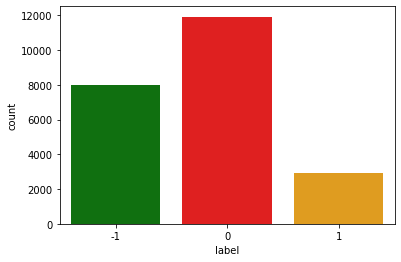

 0    11929
-1     7973
 1     2906
Name: label, dtype: int64


In [ ]:
sns.countplot(df_train["label"], palette = ["green","red","orange"])
plt.show()
print(df_train.label.value_counts())

# Validation

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


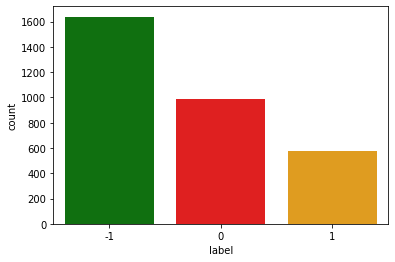

-1    1639
 0     991
 1     576
Name: label, dtype: int64


In [ ]:
sns.countplot(df_val["label"], palette = ["green","red","orange"])
plt.show()
print(df_val.label.value_counts())

# Test Dataset

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


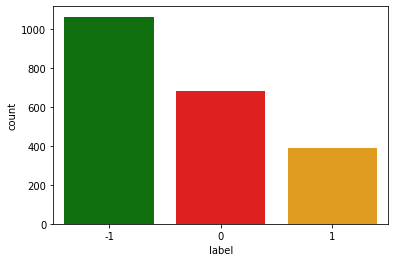

-1    1065
 0     685
 1     388
Name: label, dtype: int64


In [ ]:
sns.countplot(df_test["label"], palette = ["green","red","orange"])
plt.show()
print(df_test.label.value_counts())

# **Utility Function**

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
   # print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# **BART Model (Batch Size 10) and Inference from finetuned model**

In [ ]:

from typing import List

import torch
import torch.nn as nn
import torch.nn.functional as F


class FocalLoss(nn.Module):
    """
    Focal loss(https://arxiv.org/pdf/1708.02002.pdf)
    Shape:
        - input: (N, C)
        - target: (N)
        - Output: Scalar loss
    Examples:
        >>> loss = FocalLoss(gamma=2, alpha=[1.0]*7)
        >>> input = torch.randn(3, 7, requires_grad=True)
        >>> target = torch.empty(3, dtype=torch.long).random_(7)
        >>> output = loss(input, target)
        >>> output.backward()
    """
    def __init__(self, gamma=0, alpha: List[float] = None, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if alpha is not None:
            self.alpha = torch.FloatTensor(alpha)
        self.reduction = reduction

    def forward(self, input, target):
        # [N, 1]
        target = target.unsqueeze(-1)
        # [N, C]
        pt = F.softmax(input, dim=-1)
        logpt = F.log_softmax(input, dim=-1)
        # [N]
        pt = pt.gather(1, target).squeeze(-1)
        logpt = logpt.gather(1, target).squeeze(-1)

        if self.alpha is not None:
            # [N] at[i] = alpha[target[i]]
            at = self.alpha.gather(0, target.squeeze(-1))
            logpt = logpt * at

        loss = -1 * (1 - pt) ** self.gamma * logpt
        if self.reduction == "none":
            return loss
        if self.reduction == "mean":
            return loss.mean()
        return loss.sum()



    def __str__(self):
        return f"Focal Loss gamma:{self.gamma}"

    def __repr__(self):
        return str(self)

In [ ]:
from transformers import BartTokenizer, BartModel
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
model = BartModel.from_pretrained('facebook/bart-base')
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text



# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []
    MAX_LEN=120
    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks


# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 3

        # Instantiate BERT model
        self.bert = BartModel.from_pretrained('facebook/bart-base')


        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
        #    nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

# Specify loss function
loss_fn = FocalLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
       #     print(loss)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/532M [00:00<?, ?B/s]

In [ ]:
# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')

train_inputs, train_masks = preprocessing_for_bert(train_x)
val_inputs, val_masks = preprocessing_for_bert(val_x)
a=np.array(train_y)
b=np.array(val_y)

# Convert other data types to torch.Tensor
train_labels = torch.tensor(a+1)
val_labels = torch.tensor(b+1)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 10

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

set_seed(42)    # Set seed for reproducibility



Tokenizing data...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
bert_classifier, optimizer, scheduler = initialize_model(epochs=5) #3:51
train(bert_classifier, train_dataloader, val_dataloader, epochs=5, evaluation=True)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.082766   |     -      |     -     |   11.69  
   1    |   40    |   1.010218   |     -      |     -     |   10.87  
   1    |   60    |   0.942615   |     -      |     -     |   10.82  
   1    |   80    |   0.945401   |     -      |     -     |   10.87  
   1    |   100   |   0.896937   |     -      |     -     |   10.89  
   1    |   120   |   1.033293   |     -      |     -     |   10.94  
   1    |   140   |   1.003789   |     -      |     -     |   10.98  
   1    |   160   |   0.958405   |     -      |     -     |   11.02  
   1    |   180   |   0.978163   |     -      |     -     |   10.97  
   1    |   200   |   0.941910   |     -      |     -     |   11.08  
   1    |   220   |   0.911276   |     -      |     -     |   10.97  
   1    |   240   |   1.050901   |     -      |     -     |   10.99  


In [ ]:
import torch
#torch.save(bert_classifier, '/content/drive/MyDrive/ATIF/NLP/model2.pth')

saved_model = torch.load('/content/drive/MyDrive/model2.pth')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Confusion matrix, without normalization


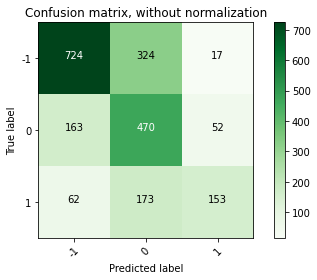

In [ ]:

test_inputs, test_masks = preprocessing_for_bert(test_x)
b=np.array(test_y)
test_labels = torch.tensor(b+1)
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
# Compute predicted probabilities on the test set
probs = bert_predict(saved_model.to(device), test_dataloader)
# Evaluate the Bert classifier
p=[]
for i in range(len(probs)):
    p.append(np.argmax(probs[i]))
cm = confusion_matrix(test_labels,p)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=['-1', '0','1'],
                      title='Confusion matrix, without normalization')



In [ ]:

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [ ]:
from math import pi
def inference(sentence):  
  testx=[]
  testy=[]
  items=['POWER','BENEVOLENCE','HEDONISM','SELF-DIRECTION','STIMULATION','UNIVERSALISM','SECURITY','ACHIEVEMENT','TRADITION','CONFORMITY']
  for i in range(10):
    testx.append('['+items[i]+'] '+ sentence)
    testy.append(1)
  test_inputs, test_masks = preprocessing_for_bert(testx)
  testx=pd.DataFrame(testx)
  test_labels = torch.tensor(np.array(testy)+1)
  test_data = TensorDataset(test_inputs, test_masks, test_labels)
  test_sampler = SequentialSampler(test_data)
  test_dataloader = DataLoader(test_data, sampler=test_sampler,batch_size=batch_size)
  probs = bert_predict(saved_model, test_dataloader)
  test_pred=[]

  for i in range(len(probs)):
    p=probs[i][np.argmax(probs[i])]
    if(np.argmax(probs[i])==0):
      test_pred.append(p-2)
    if(np.argmax(probs[i])==1):
      test_pred.append(p-1)
    if(np.argmax(probs[i])==2):
      test_pred.append(p)
  categories = items

  test_pred += test_pred[:1] # repeat the first value to close the circular graph

  angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
  angles += angles[:1]


  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8),
                       subplot_kw=dict(polar=True))

  plt.xticks(angles[:-1], categories, color='grey', size=12)
  plt.yticks(np.arange(-2, 2), ['-2','-1','0','1'],
           color='grey', size=12)
  plt.ylim(-2, 2)
  ax.set_rlabel_position(30)
  ax.plot(angles, test_pred, linewidth=1, linestyle='solid')
  ax.fill(angles, test_pred, 'skyblue', alpha=0.4)
  plt.show()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


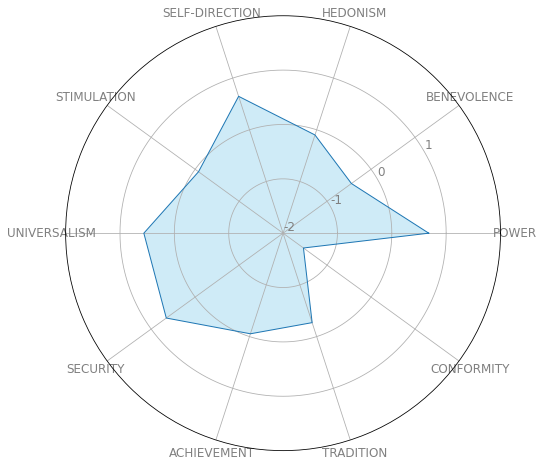

In [ ]:
inference('not wanting people to use my property without permis')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


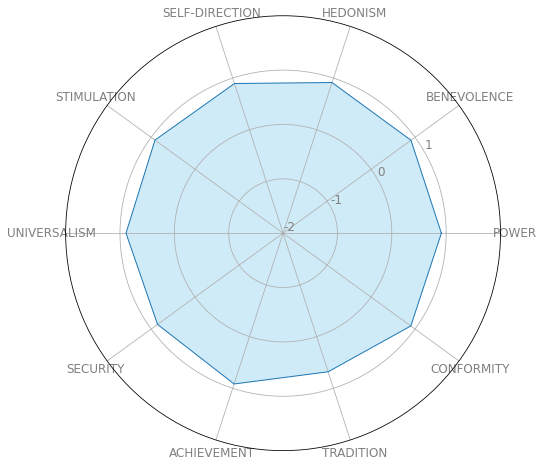

In [ ]:
inference('i love you ')

# **Model 1: BERT**

In [ ]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)
    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)
    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text
# Print sentence 0
#print('Original: ', X[0])
#print('Processed: ', text_preprocessing(X[0]))
from transformers import BertTokenizer
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []
    MAX_LEN=100
    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    return input_ids, attention_masks

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 3

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler
import random
import time
import torch.nn as nn

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()
        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0
        # Put the model into the training mode
        model.train()
        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
            # Zero out any previously calculated gradients
            model.zero_grad()
            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)
            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()
            # Perform a backward pass to calculate gradients
            loss.backward()
            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()
            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
#MAX_LEN = 90
train_inputs, train_masks = preprocessing_for_bert(train_x)
val_inputs, val_masks = preprocessing_for_bert(val_x)

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
a=np.array(train_y)
b=np.array(val_y)

# Convert other data types to torch.Tensor
train_labels = torch.tensor(a+1)
val_labels = torch.tensor(b+1)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)


In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)
# Evaluate the Bert classifier
p=[]
for i in range(len(probs)):
    p.append(np.argmax(probs[i]))
cm = confusion_matrix(val_labels,p)




In [ ]:

train(bert_classifier, train_dataloader, val_dataloader, epochs=1, evaluation=True)


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.636277   |     -      |     -     |   21.75  
   1    |   40    |   0.553082   |     -      |     -     |   20.52  
   1    |   60    |   0.629742   |     -      |     -     |   20.52  
   1    |   80    |   0.622122   |     -      |     -     |   20.46  
   1    |   100   |   0.588809   |     -      |     -     |   20.42  
   1    |   120   |   0.619391   |     -      |     -     |   20.44  
   1    |   140   |   0.589812   |     -      |     -     |   20.45  
   1    |   160   |   0.567416   |     -      |     -     |   20.51  
   1    |   180   |   0.609433   |     -      |     -     |   20.39  
   1    |   200   |   0.567311   |     -      |     -     |   20.44  
   1    |   220   |   0.599045   |     -      |     -     |   20.44  
   1    |   240   |   0.558958   |     -      |     -     |   20.40  


In [ ]:

test_inputs, test_masks = preprocessing_for_bert(test_x)


b=np.array(test_y)
test_labels = torch.tensor(b+1)
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Confusion matrix, without normalization
[[689 364  12]
 [145 513  27]
 [ 53 207 128]]


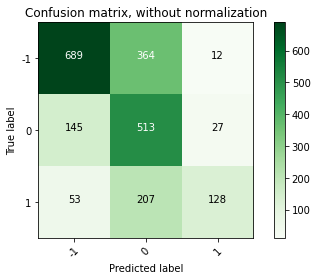

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)
# Evaluate the Bert classifier
p=[]
for i in range(len(probs)):
    p.append(np.argmax(probs[i]))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels,p)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=['-1', '0','1'],
                      title='Confusion matrix, without normalization')


# BERT achieved 62.20% accuracy on test dataset

# **Model 2: BART (Focal Loss)**

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from typing import Optional


class DiceLoss(nn.Module):
    """
    Dice coefficient for short, is an F1-oriented statistic used to gauge the similarity of two sets.
    Given two sets A and B, the vanilla dice coefficient between them is given as follows:
        Dice(A, B)  = 2 * True_Positive / (2 * True_Positive + False_Positive + False_Negative)
                    = 2 * |A and B| / (|A| + |B|)
    Math Function:
        U-NET: https://arxiv.org/abs/1505.04597.pdf
        dice_loss(p, y) = 1 - numerator / denominator
            numerator = 2 * \sum_{1}^{t} p_i * y_i + smooth
            denominator = \sum_{1}^{t} p_i + \sum_{1} ^{t} y_i + smooth
        if square_denominator is True, the denominator is \sum_{1}^{t} (p_i ** 2) + \sum_{1} ^{t} (y_i ** 2) + smooth
        V-NET: https://arxiv.org/abs/1606.04797.pdf
    Args:
        smooth (float, optional): a manual smooth value for numerator and denominator.
        square_denominator (bool, optional): [True, False], specifies whether to square the denominator in the loss function.
        with_logits (bool, optional): [True, False], specifies whether the input tensor is normalized by Sigmoid/Softmax funcs.
        ohem_ratio: max ratio of positive/negative, defautls to 0.0, which means no ohem.
        alpha: dsc alpha
    Shape:
        - input: (*)
        - target: (*)
        - mask: (*) 0,1 mask for the input sequence.
        - Output: Scalar loss
    Examples:
        >>> loss = DiceLoss(with_logits=True, ohem_ratio=0.1)
        >>> input = torch.FloatTensor([2, 1, 2, 2, 1])
        >>> input.requires_grad=True
        >>> target = torch.LongTensor([0, 1, 0, 0, 0])
        >>> output = loss(input, target)
        >>> output.backward()
    """
    def __init__(self,
                 smooth: Optional[float] = 1e-4,
                 square_denominator: Optional[bool] = False,
                 with_logits: Optional[bool] = True,
                 ohem_ratio: float = 0.0,
                 alpha: float = 0.0,
                 reduction: Optional[str] = "mean",
                 index_label_position=True) -> None:
        super(DiceLoss, self).__init__()

        self.reduction = reduction
        self.with_logits = with_logits
        self.smooth = smooth
        self.square_denominator = square_denominator
        self.ohem_ratio = ohem_ratio
        self.alpha = alpha
        self.index_label_position = index_label_position

    def forward(self, input: Tensor, target: Tensor, mask: Optional[Tensor] = None) -> Tensor:
        logits_size = input.shape[-1]
        loss = self._multiple_class(input, target, logits_size, mask=mask)


        if self.reduction == "mean":
            return loss.mean()
        if self.reduction == "sum":
            return loss.sum()
        return loss

    def _compute_dice_loss(self, flat_input, flat_target):
        flat_input = ((1 - flat_input) ** self.alpha) * flat_input
        interection = torch.sum(flat_input * flat_target, -1)
        if not self.square_denominator:
            loss = 1 - ((2 * interection + self.smooth) /
                        (flat_input.sum() + flat_target.sum() + self.smooth))
        else:
            loss = 1 - ((2 * interection + self.smooth) /
                        (torch.sum(torch.square(flat_input, ), -1) + torch.sum(torch.square(flat_target), -1) + self.smooth))

        return loss

    def _multiple_class(self, input, target, logits_size, mask=None):
        flat_input = input
        flat_target = F.one_hot(target, num_classes=logits_size).float() if self.index_label_position else target.float()
        flat_input = torch.nn.Softmax(dim=1)(flat_input) if self.with_logits else flat_input

        if mask is not None:
            mask = mask.float()
            flat_input = flat_input * mask
            flat_target = flat_target * mask
        else:
            mask = torch.ones_like(target)

        loss = None
        if self.ohem_ratio > 0 :
            mask_neg = torch.logical_not(mask)
            for label_idx in range(logits_size):
                pos_example = target == label_idx
                neg_example = target != label_idx

                pos_num = pos_example.sum()
                neg_num = mask.sum() - (pos_num - (mask_neg & pos_example).sum())
                keep_num = min(int(pos_num * self.ohem_ratio / logits_size), neg_num)

                if keep_num > 0:
                    neg_scores = torch.masked_select(flat_input, neg_example.view(-1, 1).bool()).view(-1, logits_size)
                    neg_scores_idx = neg_scores[:, label_idx]
                    neg_scores_sort, _ = torch.sort(neg_scores_idx, )
                    threshold = neg_scores_sort[-keep_num + 1]
                    cond = (torch.argmax(flat_input, dim=1) == label_idx & flat_input[:, label_idx] >= threshold) | pos_example.view(-1)
                    ohem_mask_idx = torch.where(cond, 1, 0)

                    flat_input_idx = flat_input[:, label_idx]
                    flat_target_idx = flat_target[:, label_idx]

                    flat_input_idx = flat_input_idx * ohem_mask_idx
                    flat_target_idx = flat_target_idx * ohem_mask_idx
                else:
                    flat_input_idx = flat_input[:, label_idx]
                    flat_target_idx = flat_target[:, label_idx]

                loss_idx = self._compute_dice_loss(flat_input_idx.view(-1, 1), flat_target_idx.view(-1, 1))
                if loss is None:
                    loss = loss_idx
                else:
                    loss += loss_idx
            return loss

        else:
            for label_idx in range(logits_size):
                pos_example = target == label_idx
                flat_input_idx = flat_input[:, label_idx]
                flat_target_idx = flat_target[:, label_idx]

                loss_idx = self._compute_dice_loss(flat_input_idx.view(-1, 1), flat_target_idx.view(-1, 1))
                if loss is None:
                    loss = loss_idx
                else:
                    loss += loss_idx
            return loss



    def __str__(self):
        return f"Dice Loss smooth:{self.smooth}, ohem: {self.ohem_ratio}, alpha: {self.alpha}"

    def __repr__(self):
        return str(self)

In [ ]:

from typing import List

import torch
import torch.nn as nn
import torch.nn.functional as F


class FocalLoss(nn.Module):
    """
    Focal loss(https://arxiv.org/pdf/1708.02002.pdf)
    Shape:
        - input: (N, C)
        - target: (N)
        - Output: Scalar loss
    Examples:
        >>> loss = FocalLoss(gamma=2, alpha=[1.0]*7)
        >>> input = torch.randn(3, 7, requires_grad=True)
        >>> target = torch.empty(3, dtype=torch.long).random_(7)
        >>> output = loss(input, target)
        >>> output.backward()
    """
    def __init__(self, gamma=0, alpha: List[float] = None, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if alpha is not None:
            self.alpha = torch.FloatTensor(alpha)
        self.reduction = reduction

    def forward(self, input, target):
        # [N, 1]
        target = target.unsqueeze(-1)
        # [N, C]
        pt = F.softmax(input, dim=-1)
        logpt = F.log_softmax(input, dim=-1)
        # [N]
        pt = pt.gather(1, target).squeeze(-1)
        logpt = logpt.gather(1, target).squeeze(-1)

        if self.alpha is not None:
            # [N] at[i] = alpha[target[i]]
            at = self.alpha.gather(0, target.squeeze(-1))
            logpt = logpt * at

        loss = -1 * (1 - pt) ** self.gamma * logpt
        if self.reduction == "none":
            return loss
        if self.reduction == "mean":
            return loss.mean()
        return loss.sum()



    def __str__(self):
        return f"Focal Loss gamma:{self.gamma}"

    def __repr__(self):
        return str(self)

In [ ]:
from transformers import BartTokenizer, BartModel
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
model = BartModel.from_pretrained('facebook/bart-base')
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text



# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []
    MAX_LEN=120
    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks


# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 3

        # Instantiate BERT model
        self.bert = BartModel.from_pretrained('facebook/bart-base')


        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
        #    nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

# Specify loss function
loss_fn = FocalLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
       #     print(loss)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/532M [00:00<?, ?B/s]

In [ ]:
# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')

train_inputs, train_masks = preprocessing_for_bert(train_x)
val_inputs, val_masks = preprocessing_for_bert(val_x)
a=np.array(train_y)
b=np.array(val_y)

# Convert other data types to torch.Tensor
train_labels = torch.tensor(a+1)
val_labels = torch.tensor(b+1)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

set_seed(42)    # Set seed for reproducibility



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Tokenizing data...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
bert_classifier, optimizer, scheduler = initialize_model(epochs=4) #3:51
train(bert_classifier, train_dataloader, val_dataloader, epochs=4, evaluation=True)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.013932   |     -      |     -     |   14.62  
   1    |   40    |   0.956023   |     -      |     -     |   14.09  
   1    |   60    |   0.976452   |     -      |     -     |   14.32  
   1    |   80    |   0.939686   |     -      |     -     |   14.48  
   1    |   100   |   0.927717   |     -      |     -     |   14.64  
   1    |   120   |   0.945867   |     -      |     -     |   14.52  
   1    |   140   |   0.924800   |     -      |     -     |   14.41  
   1    |   160   |   0.910879   |     -      |     -     |   14.35  
   1    |   180   |   0.906811   |     -      |     -     |   14.43  
   1    |   200   |   0.897979   |     -      |     -     |   14.51  
   1    |   220   |   0.881087   |     -      |     -     |   14.58  
   1    |   240   |   0.916449   |     -      |     -     |   14.44  


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Confusion matrix, without normalization


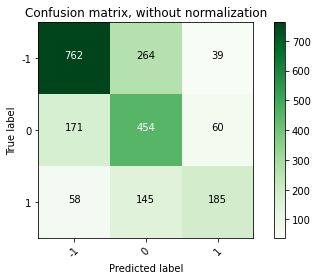

In [ ]:

test_inputs, test_masks = preprocessing_for_bert(test_x)
b=np.array(test_y)
test_labels = torch.tensor(b+1)
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)
# Evaluate the Bert classifier
p=[]
for i in range(len(probs)):
    p.append(np.argmax(probs[i]))
cm = confusion_matrix(test_labels,p)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=['-1', '0','1'],
                      title='Confusion matrix, without normalization')



# BART achieved 65.53%

# **Model 2: BART (Cross Entropy Loss)**

In [ ]:
from transformers import BartTokenizer, BartModel
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
model = BartModel.from_pretrained('facebook/bart-base')
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text



# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []
    MAX_LEN=120
    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks


# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 3

        # Instantiate BERT model
        self.bert = BartModel.from_pretrained('facebook/bart-base')


        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
        #    nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [ ]:
# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')

train_inputs, train_masks = preprocessing_for_bert(train_x)
val_inputs, val_masks = preprocessing_for_bert(val_x)
a=np.array(train_y)
b=np.array(val_y)

# Convert other data types to torch.Tensor
train_labels = torch.tensor(a+1)
val_labels = torch.tensor(b+1)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

set_seed(42)    # Set seed for reproducibility



Tokenizing data...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
bert_classifier, optimizer, scheduler = initialize_model(epochs=5)
train(bert_classifier, train_dataloader, val_dataloader, epochs=5, evaluation=True)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.003806   |     -      |     -     |   40.38  
   1    |   40    |   0.960149   |     -      |     -     |   38.34  
   1    |   60    |   0.977533   |     -      |     -     |   38.31  
   1    |   80    |   0.949358   |     -      |     -     |   38.29  
   1    |   100   |   0.937102   |     -      |     -     |   38.29  
   1    |   120   |   0.928647   |     -      |     -     |   38.29  
   1    |   140   |   0.930907   |     -      |     -     |   38.29  
   1    |   160   |   0.923306   |     -      |     -     |   38.28  
   1    |   180   |   0.919479   |     -      |     -     |   38.29  
   1    |   200   |   0.918014   |     -      |     -     |   38.29  
   1    |   220   |   0.914100   |     -      |     -     |   38.29  
   1    |   240   |   0.947163   |     -      |     -     |   38.29  


Confusion matrix, without normalization
[[691 336  38]
 [145 484  56]
 [ 52 165 171]]


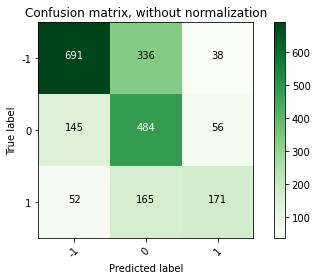

In [ ]:

test_inputs, test_masks = preprocessing_for_bert(test_x)
b=np.array(test_y)
test_labels = torch.tensor(b+1)
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)
# Evaluate the Bert classifier
p=[]
for i in range(len(probs)):
    p.append(np.argmax(probs[i]))
cm = confusion_matrix(test_labels,p)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=['-1', '0','1'],
                      title='Confusion matrix, without normalization')



# BART Achieved 63% accuracy on test Dataset

# **Model3: Roberta**

In [ ]:
#Load the set
train_df=pd.read_csv('/content/drive/MyDrive/Projects/ValueNet/v0.3_augmented/train.csv')

train_li=[]
for i in range(len(train_df)):
        train_li.append(train_df.iloc[i,0].split("]",1)[1])

train_df['Text']=train_li
train_df.head()

In [ ]:


class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)
        
config = Config(
    testing=False,
    seed = 2019,
    roberta_model_name='roberta-base', # can also be exchnaged with roberta-large 
    max_lr=1e-5,
    epochs=1,
    use_fp16=False,
    bs=4, 
    max_seq_len=512, 
    num_labels = 2,
    hidden_dropout_prob=.05,
    hidden_size=768, # 1024 for roberta-large
    start_tok = "<s>",
    end_tok = "</s>",
)
class FastAiRobertaTokenizer(BaseTokenizer):
    """Wrapper around RobertaTokenizer to be compatible with fastai"""
    def __init__(self, tokenizer: RobertaTokenizer, max_seq_len: int=128, **kwargs): 
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len 
    def __call__(self, *args, **kwargs): 
        return self 
    def tokenizer(self, t:str) -> List[str]: 
        """Adds Roberta bos and eos tokens and limits the maximum sequence length""" 
        return [config.start_tok] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + [config.end_tok]
# create fastai tokenizer for roberta
roberta_tok = RobertaTokenizer.from_pretrained("roberta-base")

fastai_tokenizer = Tokenizer(tok_func=FastAiRobertaTokenizer(roberta_tok, max_seq_len=config.max_seq_len), 
                             pre_rules=[], post_rules=[])
# create fastai vocabulary for roberta
path = Path()
roberta_tok.save_vocabulary(path)

with open('vocab.json', 'r') as f:
    roberta_vocab_dict = json.load(f)
    
fastai_roberta_vocab = Vocab(list(roberta_vocab_dict.keys()))

# Setting up pre-processors
class RobertaTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
         super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)

class RobertaNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=fastai_roberta_vocab, **kwargs)


def get_roberta_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    Constructing preprocessors for Roberta
    We remove sos and eos tokens since we add that ourselves in the tokenizer.
    We also use a custom vocabulary to match the numericalization with the original Roberta model.
    """
    return [RobertaTokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(vocab=vocab)]
# Creating a Roberta specific DataBunch class
class RobertaDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training Roberta"
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=64, val_bs:int=None, pad_idx=1,
               pad_first=True, device:torch.device=None, no_check:bool=False, backwards:bool=False, 
               dl_tfms:Optional[Collection[Callable]]=None, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(pad_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, dl_tfms=dl_tfms, collate_fn=collate_fn, no_check=no_check)
class RobertaTextList(TextList):
    _bunch = RobertaDataBunch
    _label_cls = TextList

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
# loading the tokenizer and vocab processors
processor = get_roberta_processor(tokenizer=fastai_tokenizer, vocab=fastai_roberta_vocab)

# creating our databunch 
data = RobertaTextList.from_df(train_df, ".", cols="Text", processor=processor) \
    .split_by_rand_pct(seed=config.seed) \
    .label_from_df(cols="label",label_cls=CategoryList) \
    .databunch(bs=config.bs, pad_first=False, pad_idx=0)

In [ ]:

# defining our model architecture 
class CustomRobertaModel(nn.Module):
    def __init__(self,num_labels=3):
        super(CustomRobertaModel,self).__init__()
        self.num_labels = num_labels
        self.roberta = RobertaModel.from_pretrained(config.roberta_model_name,return_dict=False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, num_labels) # defining final output layer
        
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _ , pooled_output = self.roberta(input_ids, token_type_ids, attention_mask) # 
        logits = self.classifier(pooled_output)        
        return logits
roberta_model = CustomRobertaModel()

learn = Learner(data, roberta_model, metrics=[accuracy])

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
learn.model.roberta.train() # setting roberta to train as it is in eval mode by default
learn.fit_one_cycle(config.epochs, max_lr=config.max_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.887193,0.847793,0.585179,11:56


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
